In [5]:
import numpy as np
from skimage import img_as_float
from scipy.ndimage import uniform_filter
from skimage.filters import threshold_otsu

In [6]:
def detect_cells_std(image, window_size=15, threshold_factor=1.0):
    img_float=img_as_float(image)
    local_mean=uniform_filter(img_float, size=window_size)
    local_squared_mean=uniform_filter(img_float**2, size=window_size)
    local_std=np.sqrt(np.maximum(local_squared_mean - local_mean**2,0))
    std_threshold=threshold_otsu(local_std) * threshold_factor
    
    cell_mask = local_std > std_threshold
    
    return cell_mask, local_std

In [7]:
def preprocess_he_image(image):
    gray = (image[:,:,0] * 0.299 +
           image[:,:,1] * 0.587 +
           image[:,:,2] * 0.114)
    return gray

In [8]:
def analyze_cell_regions(mask):
    total_pixels = mask.size
    cell_pixels = np.sum(mask)
    cellularity = cell_pixels / total_pixels * 100
    
    return {
        'cellularity_percentage': cellularity,
        'cell_area_pixels': cell_pixels,
        'total_area_pixels': total_pixels
    }

In [9]:
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import cv2

def visualize_results(original_image, cell_mask, std_map):
    mask_uint8=img_as_ubyte(cell_mask)
    overlay = original_image.copy()
    overlay[cell_mask] = [0,255,0]  #green
    
    #blending
    alpha=0.3
    blended=cv2.addWeighted(original_image,1-alpha,overlay,alpha,0)
    
    plt.figure(figsize=(15,5))
    
    #original_image
    plt.subplot(141)
    plt.imshow(cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB))
    plt.title('Original image')
    plt.axis('off')
    
    #binary mask
    plt.subplot(142)
    plt.imshow(mask_uint8, cmap='binary')
    plt.title('Cell mask')
    plt.axis('off')
    
    #std map
    plt.subplot(143)
    plt.imshow(std_map, cmap='hot')
    plt.title('STD Map')
    plt.colorbar()
    plt.axis('off')
    
    # Overlay
    plt.subplot(144)
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    plt.title('Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

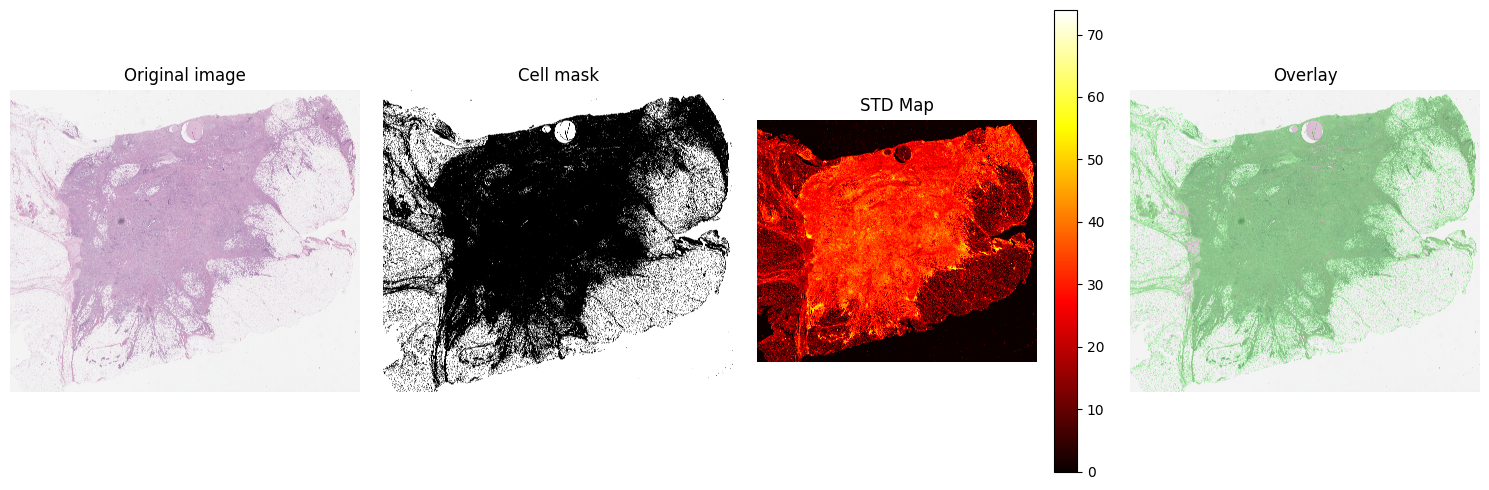

In [10]:
image=cv2.imread('images/example.png')

gray=preprocess_he_image(image)

cell_mask, std_map = detect_cells_std(gray,
                                     window_size=15,
                                     threshold_factor=1.0)
visualize_results(image,cell_mask,std_map)